In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.style.available


['seaborn-paper',
 'fivethirtyeight',
 'seaborn-poster',
 'bmh',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-deep',
 'ggplot',
 'classic',
 'seaborn',
 'seaborn-dark',
 'seaborn-ticks',
 'seaborn-pastel',
 'seaborn-muted',
 'seaborn-darkgrid',
 'tableau-colorblind10',
 'Solarize_Light2',
 'seaborn-white',
 'seaborn-talk',
 'seaborn-notebook',
 'seaborn-colorblind',
 'dark_background',
 'grayscale',
 'fast',
 '_classic_test',
 'seaborn-whitegrid']

In [9]:
import os
csv = dict()

def register(project_name):
    csv_name = project_name + '_output.txt'
    csv_path = os.path.join(os.path.expanduser('~'), 'Dropbox','shared','Python scripts', 'LazyUT_TEST', csv_name)
    csv[project_name] = pd.read_csv(csv_path)

projects = ['botan1']
for p in projects:
    register(p)

---- PROJECT botan1 ----
mode_data.v_lazyut_time[8.1052, 8.0764, 7.7828, 7.127000000000001, 7.4318, 7.1673]
mode_data.v_preprocessor_time[103.37, 104.69, 93.912, 95.72399999999999, 94.223, 89.322]


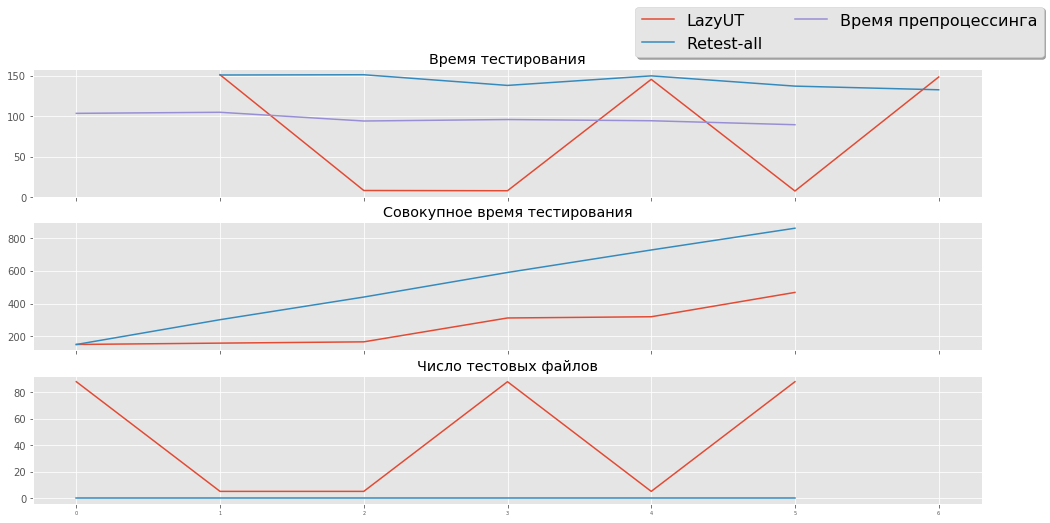

In [17]:
class ModeData:
    def __init__(self, mode):
        self.mode = mode
        self.v_num_test = []
        self.v_preprocessor_time = []
        self.v_lazyut_time = []
        self.v_testing_time = []
        self.v_cum_testing_time = []
    def size(self):
        return len(self.v_testing_time)
    def name(self):
        if self.mode == 'test-affected':
            return 'LazyUT'
        if self.mode == 'test-all':
            return 'Retest-all'
        return 'unknown'

def make_mode_data(csv, mode):
    mode_data = ModeData(mode)
    csv_commits = csv.loc[csv['MODE'] == mode].groupby('COMMIT')
    cum_time = 0
    for commit, data in csv_commits:
        test_time = data.TEST.mean()
        if mode == 'test-affected':
            test_time += data.ANALYSIS.mean()
        cum_time += test_time
        mode_data.v_testing_time.append(test_time)
        mode_data.v_cum_testing_time.append(cum_time)
        mode_data.v_num_test.append(data.FILES.max())
        mode_data.v_preprocessor_time.append(data.PREPROCESSOR.mean())
        mode_data.v_lazyut_time.append(data.ANALYSIS.mean())
    return mode_data
    
def make_plots(csv):
    def modes_data(csv, modes):
        for mode_str in modes:
            yield make_mode_data(csv, mode_str)
    
    plt.figure(figsize=(17,8))
    for mode_data in modes_data(csv, ['test-affected', 'test-all']):
        ax1 = plt.subplot(3, 1, 1)
        ax1.set_title('Время тестирования')
        plt.plot(range(1, mode_data.size() + 1), mode_data.v_testing_time, label=mode_data.name())
        plt.setp(ax1.get_xticklabels(), visible=False)
        
        if mode_data.mode == 'test-all':
            print('mode_data.v_preprocessor_time' + str(mode_data.v_preprocessor_time))
            plt.plot(mode_data.v_preprocessor_time, label='Время препроцессинга')
        elif mode_data.mode == 'test-affected':
            print('mode_data.v_lazyut_time' + str(mode_data.v_lazyut_time))
        
        plt.legend(loc='upper center', bbox_to_anchor=(0.85, 1.55), prop={'size': 16},
          ncol=2, fancybox=True, shadow=True)
        
        ax2 = plt.subplot(3, 1, 2, sharex = ax1)
        ax2.set_title('Совокупное время тестирования')
        plt.plot(mode_data.v_cum_testing_time, label=mode_data.mode)
        plt.setp(ax2.get_xticklabels(), visible=False)
        
        ax3 = plt.subplot(3, 1, 3, sharex = ax1)
        ax3.set_title('Число тестовых файлов')
        plt.plot(mode_data.v_num_test, label=mode_data.mode)
        plt.setp(ax3.get_xticklabels(), fontsize=5)
        
    plt.show()
    # number of test files
    # testing time
    # cumulative testing time

for p in projects:
    print('---- PROJECT {} ----'.format(p))
    make_plots(csv[p])